# XXZ model


In [30]:
# qibo's
import qibo
from qibo import gates, hamiltonians, models
from qibo.backends import construct_backend
from qibo.models.dbi.double_bracket import (
    DoubleBracketGeneratorType,
    DoubleBracketIteration,
)


# boostvqe's
from boostvqe import ansatze
from boostvqe.plotscripts import plot_gradients, plot_loss
from boostvqe.training_utils import Model, vqe_loss, TLFIM
from boostvqe.models.dbi.double_bracket_evolution_oracles import *
from boostvqe.utils import (
    OPTIMIZATION_FILE,
    PARAMS_FILE,
    optimize_D,
    select_recursion_step_gd_circuit,
    apply_dbi_steps,
    create_folder,
    generate_path,
    results_dump,
    rotate_h_with_vqe,
    train_vqe,
)
from boostvqe.models.dbi.group_commutator_iteration_transpiler import (
    DoubleBracketRotationType,
    GroupCommutatorIterationWithEvolutionOracles,
)
import numpy as np
import json
import matplotlib.pyplot as plt

In [3]:
# helper functions
def exact_expectation_boost(ham, circ):
    # calculates the exact expectation of hamiltonian given a circuit in qibo
    return ham.expectation(
        ham.backend.execute_circuit(circuit=circ).state())

In [11]:
qibo.set_backend("numpy")
vqe_backend = construct_backend(backend="numpy")

[Qibo 0.2.12|INFO|2024-10-23 15:47:40]: Using numpy backend on /CPU:0
INFO:qibo.config:Using numpy backend on /CPU:0


[Qibo 0.2.12|WARNING|2024-10-23 15:48:11]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.


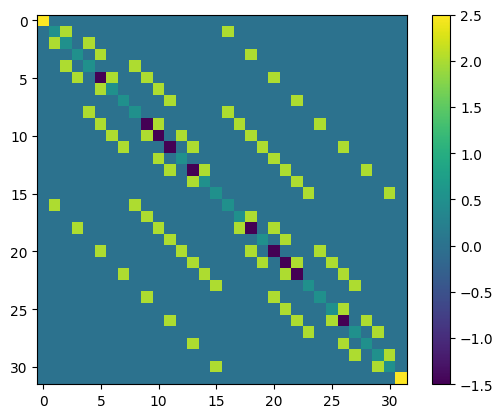

In [13]:
nqubits = 5
delta = 0.5
ham = hamiltonians.XXZ(nqubits, delta, dense=False)
plt.imshow(np.real(ham.matrix))
plt.colorbar()

In [20]:
nqubits = 5
nlayers = 3
epochs = 100
path = "./results/big_architectures_small_lr/sgd_5q_3l_42/"
OPTIMIZATION_METHOD="sgd"
OPTIMIZATION_CONFIG="{ \"maxiter\": 2, \"gd_epochs\":2}"

In [21]:
# load data
opt_options = json.loads(OPTIMIZATION_CONFIG)

params = np.array(
    np.load(path + PARAMS_FILE, allow_pickle=True).tolist()[0][epochs]
)

In [22]:
# create ansatze circuit
ansatz_circ = ansatze.hdw_efficient(nqubits, nlayers)

In [23]:
# setup vqe
vqe = ansatze.VQE(
        circuit=ansatz_circ,
        hamiltonian=ham,
    )
vqe.circuit.set_parameters(params)

In [24]:
# step: Number of time steps (default 1).
# order: the order of product formula, as of now, it takes value 1 or 2
steps = 1
order = 1
ham_base_eo = XXZ_EvolutionOracle.from_nqubits(
        nqubits=nqubits, delta=0.5, steps=steps, order=order
    )

In [29]:
# we then rotrate H_XXZ with VQE using the FrameShiftedOracle e^{i H' t} = V e^{i H0 t} Vdag
frame_shifted_oracle = FrameShiftedEvolutionOracle.from_evolution_oracle(
        before_circuit=vqe.circuit.invert(),
        after_circuit = vqe.circuit,
        base_evolution_oracle=ham_base_eo,)

In [ ]:
# shifted oracle is passed to the group commutator
db_rotation = DoubleBracketRotationType.group_commutator_third_order_reduced
gci = GroupCommutatorIterationWithEvolutionOracles(
    frame_shifted_oracle
    db_rotation,
)